In [221]:
!pip install extinction
# remove if duplicate
import pandas as pd
import numpy as np
import os
import glob
from extinction import fitzpatrick99
import matplotlib.pyplot as plt
import seaborn as sns

In [222]:
DATA_DIR = "mallorn-challenge/"
WAVELENGTHS = {'u': 3641, 'g': 4704, 'r': 6155, 'i': 7504, 'z': 8695, 'y': 10056}
log_df = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
print(log_df.head(), log_df.shape)

                  object_id       Z  Z_err    EBV SpecType  \
0  Dornhoth_fervain_onodrim  3.0490    NaN  0.110      AGN   
1       Dornhoth_galadh_ylf  0.4324    NaN  0.058    SN II   
2      Elrim_melethril_thul  0.4673    NaN  0.577      AGN   
3        Ithil_tobas_rodwen  0.6946    NaN  0.012      AGN   
4       Mirion_adar_Druadan  0.4161    NaN  0.058      AGN   

                               English Translation     split  target  
0  Trawn Folk (Dwarfs) + northern + Ents (people)   split_01       0  
1    Trawn Folk (Dwarfs) + tree + drinking vessel   split_01       0  
2                  Elves +  lover (fem.)  + breath  split_01       0  
3                    moon +  roof  +  noble maiden  split_01       0  
4            jewel, Silmaril  + father + Wild Man   split_01       0   (3043, 8)


Amount of duplicate object_id: 0

Amount of missing values (NA) in each column:
object_id                 0
Z                         0
Z_err                  3043
EBV                       0
SpecType                  0
English Translation       0
split                     0
target                    0
dtype: int64


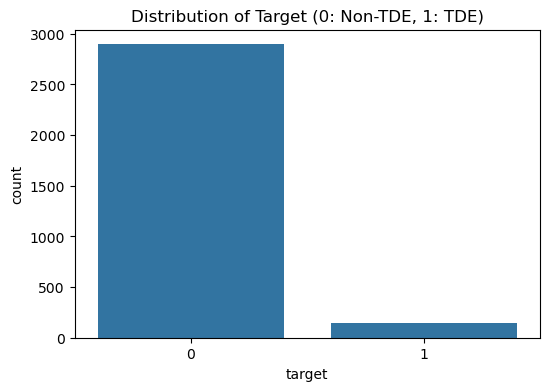

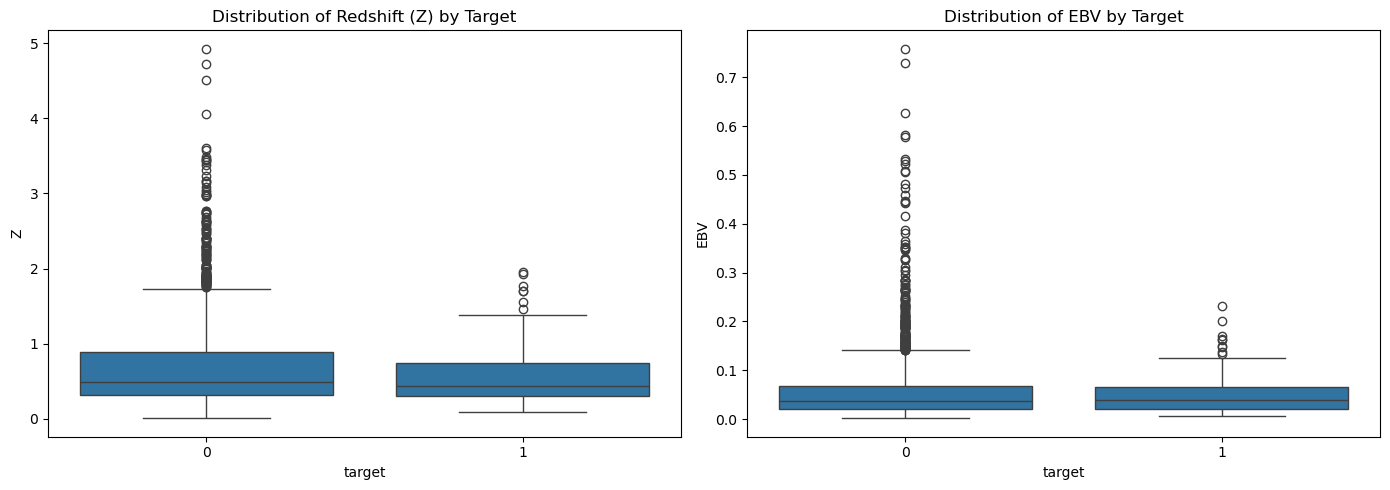

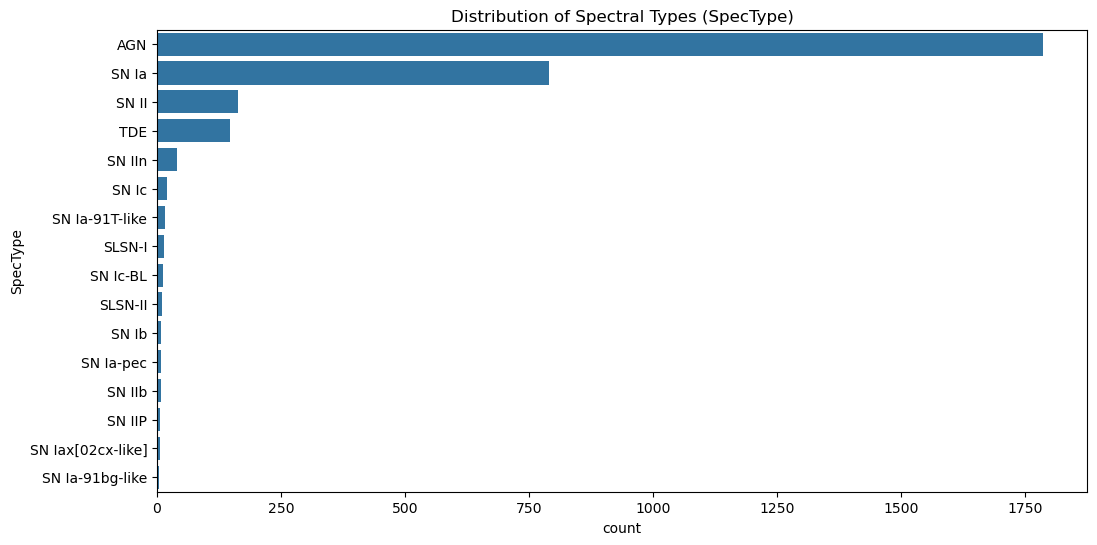

In [223]:
# 2.1. Check data quality (EDA Metadata)

# 1. Check duplicate object_id
n_duplicates = log_df['object_id'].duplicated().sum()
print(f"Amount of duplicate object_id: {n_duplicates}")

# 2. Count NA in each column
print("\nAmount of missing values (NA) in each column:")
print(log_df.isna().sum())

# 3. View target distribution (Class Imbalance)
plt.figure(figsize=(6, 4))
sns.countplot(data=log_df, x='target')
plt.title("Distribution of Target (0: Non-TDE, 1: TDE)")
plt.show()

# 4. Histogram / Boxplot of Z, EBV by target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Redshift (Z)
sns.boxplot(data=log_df, x='target', y='Z', ax=axes[0])
axes[0].set_title("Distribution of Redshift (Z) by Target")

# EBV
sns.boxplot(data=log_df, x='target', y='EBV', ax=axes[1])
axes[1].set_title("Distribution of EBV by Target")

plt.tight_layout()
plt.show()

# 5. Distribution of SpecType (if available)
if 'SpecType' in log_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=log_df, y='SpecType', order=log_df['SpecType'].value_counts().index)
    plt.title("Distribution of Spectral Types (SpecType)")
    plt.show()
else:
    print("\nSpecType column not found in the data.")

**1. Some feedback personality here**
Non-TDE(target=0)≈2900
TDE(target=1)≈100-150
-> Imply this is imbalanced data problem--> consider use over sampling or under sampling techniques
-> if use model normally ML-> always predict non-TDE, high accuracy but useless model
-> apply 
- class weight in model training
- focal loss function
- oversampling techniques like SMOTE
- anomaly detection models

**2. RedShift**(Z) follow target"
Observed that Medians of botth class are similar
IQR(Interquartile Range) is quite stack together
non-TDE have many outliers(2-5), TDE have few outliers(0-1)
Conclusion:
Z is not strong feature to distinguish TDE and non-TDE
But Non-TDE have many objects in high redshift
TDE have redshift less than 1
-> secondary feature

**3. EBV dust extinction**
Median same 90%
Non-TDE have many outlier EBV (>=0.4-0.8)
EBV is not enough to distinct TDE


In [224]:
def process_flux(df):
    eps = 1e-6
    flux_err_safe = df['Flux_err'].replace(0, np.nan)
    denom = np.power(flux_err_safe, 2) + eps
    flux_ratio_sq = np.power(df['Flux'], 2) / denom
    df_flux = pd.DataFrame({
        'flux_ratio_sq': flux_ratio_sq,
        'flux_by_flux_ratio_sq': df['Flux'] * flux_ratio_sq
    }, index=df.index)
    return pd.concat([df, df_flux], axis=1)


In [225]:
def apply_de_extinction(df):
    wl_values = df['Filter'].map(WAVELENGTHS)
    ebv_values = df['EBV'].astype(float)

    a_lambda = np.full(len(df), np.nan)
    valid = ~wl_values.isna()
    if valid.any():
        unit_extinction = fitzpatrick99(wl_values[valid].values.astype(float), 1.0)
        a_lambda[valid] = unit_extinction * (ebv_values[valid] * 3.1)

    df['Flux_Real'] = df['Flux'] * (10 ** (a_lambda / 2.5))
    return df


In [226]:
def process_data_pipeline(log_df, is_train=True):
    file_name = "train_full_lightcurves.csv" if is_train else "test_full_lightcurves.csv"
    cols_to_use = ['object_id', 'EBV', 'Z']
    if is_train:
        cols_to_use.append('target')

    log_lookup = log_df[cols_to_use]
    all_features = []
    for i in range(1, 21):
        split_path = os.path.join(DATA_DIR, f"Split_{i:02d}", file_name)
        if os.path.exists(split_path):
            print(f"Processing {split_path}...")
            chunk_df = pd.read_csv(split_path)
            chunk_df = chunk_df.merge(log_lookup[['object_id', 'EBV', 'Z']], on='object_id', how='left')
            chunk_df = apply_de_extinction(chunk_df)
            chunk_df = process_flux(chunk_df)
            agg_dict = {
                'Flux_Real': ['max', 'mean', 'min', 'std'],
                'Time (MJD)': ['min', 'max'],
                'flux_ratio_sq': ['max', 'mean', 'min', 'std'],
                'flux_by_flux_ratio_sq': ['max', 'mean', 'min', 'std']
            }
            features = chunk_df.groupby(['object_id', 'Filter']).agg(agg_dict)
            features = features.unstack()
            features.columns = ['_'.join(map(str, col)).strip() for col in features.columns.values]
            features = features.reset_index()
            features = features.merge(log_lookup[['object_id', 'Z']], on='object_id', how='left')
            features['is_galactic'] = (features['Z'] < 0.005).astype(int)
            features['Log_Z'] = np.log1p(features['Z'])
            if 'Flux_Real_max_g' in features.columns and 'Flux_Real_max_r' in features.columns:
                features['color_g_r'] = features['Flux_Real_max_g'] - features['Flux_Real_max_r']
            else:
                features['color_g_r'] = np.nan
            if 'Flux_Real_max_u' in features.columns and 'Flux_Real_max_g' in features.columns:
                features['color_u_g'] = features['Flux_Real_max_u'] - features['Flux_Real_max_g']
            else:
                features['color_u_g'] = np.nan
            if 'Time_max_g' in features.columns and 'Time_min_g' in features.columns:
                duration_obs = features['Time_max_g'] - features['Time_min_g']
                features['duration_rest'] = duration_obs / (1 + features['Z'])
            else:
                features['duration_rest'] = np.nan
            all_features.append(features)
            del chunk_df
    if len(all_features) > 0:
        final_df = pd.concat(all_features, ignore_index=True)
        if is_train:
            final_df = final_df.merge(log_lookup[['object_id', 'target']], on='object_id', how='left')
        return final_df
    else:
        print("No data files found.")
        return None


In [227]:
# Step 1 Read file log
print(" Reading doc files log...")
train_log = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
# Step 2 Call function process_data_pipeline to process data
print(" Processing training data...")
final_df = process_data_pipeline(train_log, is_train=True)
# Step 3 Check conclusions
if final_df is not None:
    print(" Final training data shape:", final_df.shape)
else:
    print(" Data processing failed.")


 Reading doc files log...
 Processing training data...
Processing mallorn-challenge/Split_01\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_02\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_03\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_04\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_05\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_06\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_07\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_08\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_09\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_10\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_11\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_12\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_06\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_07\train_full_lightcurves.

In [228]:
# Compute full-data stats for inference (do NOT modify final_df; avoid leakage into CV)
X_full_raw = final_df.drop(columns=['object_id', 'target'])

a_ratio_full = X_full_raw.isna().mean()
cols_drop_full = a_ratio_full[a_ratio_full > 0.8].index

# Column types
num_cols_full = X_full_raw.select_dtypes(include=['float', 'int']).columns
cat_cols_full = X_full_raw.select_dtypes(exclude=['float', 'int']).columns

# Fit imputers on full train (for final fit / test inference only)
train_num_median_full = X_full_raw[num_cols_full].median()
train_cat_mode_full = X_full_raw[cat_cols_full].mode().iloc[0] if len(cat_cols_full) > 0 else pd.Series()

# Fit clip bounds on full train
lower_full = X_full_raw[num_cols_full].quantile(0.01)
upper_full = X_full_raw[num_cols_full].quantile(0.99)

# Build a fully cleaned version for optional full-data training/inference
X_full_clean = X_full_raw.drop(columns=cols_drop_full)
num_cols_clean = [c for c in num_cols_full if c not in cols_drop_full]
cat_cols_clean = [c for c in cat_cols_full if c not in cols_drop_full]
if len(num_cols_clean) > 0:
    X_full_clean[num_cols_clean] = X_full_clean[num_cols_clean].fillna(train_num_median_full[num_cols_clean])
    X_full_clean[num_cols_clean] = X_full_clean[num_cols_clean].clip(lower=lower_full[num_cols_clean], upper=upper_full[num_cols_clean], axis=1)
if len(cat_cols_clean) > 0 and not train_cat_mode_full.empty:
    X_full_clean[cat_cols_clean] = X_full_clean[cat_cols_clean].fillna(train_cat_mode_full[cat_cols_clean])

feature_cols_full = X_full_clean.columns
print("Computed full-data stats for inference; kept final_df raw for CV.")


Computed full-data stats for inference; kept final_df raw for CV.


In [229]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

# Prepare labels and groups
y = final_df['target'].values
object_ids = final_df['object_id'].values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds_proba = np.zeros(len(final_df))
models = []
print("🚀 Starting LightGBM training with per-fold preprocessing (no leakage)...")

for fold, (train_idx, val_idx) in enumerate(kf.split(final_df, y)):
    train_df = final_df.iloc[train_idx].copy()
    val_df = final_df.iloc[val_idx].copy()

    # Drop high-NA columns based on train fold only
    X_train_raw = train_df.drop(columns=['object_id', 'target'])
    na_ratio = X_train_raw.isna().mean()
    cols_drop_fold = na_ratio[na_ratio > 0.8].index

    X_train = X_train_raw.drop(columns=cols_drop_fold)
    X_val = val_df.drop(columns=['object_id', 'target']).drop(columns=cols_drop_fold, errors='ignore')

    # Impute based on train fold
    num_cols = X_train.select_dtypes(include=['float', 'int']).columns
    cat_cols = X_train.select_dtypes(exclude=['float', 'int']).columns
    num_median = X_train[num_cols].median()
    cat_mode = X_train[cat_cols].mode().iloc[0] if len(cat_cols) > 0 else pd.Series()

    if len(num_cols) > 0:
        X_train[num_cols] = X_train[num_cols].fillna(num_median)
        X_val[num_cols] = X_val[num_cols].fillna(num_median)
    if len(cat_cols) > 0 and not cat_mode.empty:
        X_train[cat_cols] = X_train[cat_cols].fillna(cat_mode)
        X_val[cat_cols] = X_val[cat_cols].fillna(cat_mode)

    # Clip outliers using train fold percentiles
    if len(num_cols) > 0:
        lower = X_train[num_cols].quantile(0.01)
        upper = X_train[num_cols].quantile(0.99)
        X_train[num_cols] = X_train[num_cols].clip(lower=lower, upper=upper, axis=1)
        X_val[num_cols] = X_val[num_cols].clip(lower=lower, upper=upper, axis=1)

    y_train = train_df['target'].values
    y_val = val_df['target'].values

    # Apply SMOTE on the preprocessed train fold only
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_val, y_val)])

    val_preds_proba = model.predict_proba(X_val)[:, 1]
    oof_preds_proba[val_idx] = val_preds_proba
    models.append(model)

    temp_preds = (val_preds_proba >= 0.5).astype(int)
    score = f1_score(y_val, temp_preds)
    print(f"Fold {fold+1}: F1-Score (Default 0.5) = {score:.4f}")

# Track last feature columns for feature importance
feature_cols_last_fold = X_train.columns


🚀 Starting LightGBM training with per-fold preprocessing (no leakage)...
Fold 1: F1-Score (Default 0.5) = 0.2857
Fold 1: F1-Score (Default 0.5) = 0.2857
Fold 2: F1-Score (Default 0.5) = 0.1786
Fold 2: F1-Score (Default 0.5) = 0.1786
Fold 3: F1-Score (Default 0.5) = 0.2593
Fold 3: F1-Score (Default 0.5) = 0.2593
Fold 4: F1-Score (Default 0.5) = 0.3448
Fold 4: F1-Score (Default 0.5) = 0.3448
Fold 5: F1-Score (Default 0.5) = 0.3019
Fold 5: F1-Score (Default 0.5) = 0.3019


In [230]:
import enum
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, f1_score, average_precision_score
from sympy import oo

# oof_probas: np.array of OOF positive class probabilities (len = y)
# y: true labels aligned to oof_probas

precision, recall, thresholds = precision_recall_curve(y, oof_preds_proba)
f1_scores = 2 * recall * precision / (recall + precision + 1e-9)

if len(thresholds) == 0:
    best_threshold = 0.5
    print("precision_recall_curve returned empty thresholds; defaulting threshold to 0.5")
else:
    best_index = np.nanargmax(f1_scores[:-1])  # f1_scores has len(thresholds)+1
    best_threshold = thresholds[best_index]

pr_auc = average_precision_score(y, oof_preds_proba)
print (f"OFF best F1={np.nanmax(f1_scores):.4f} at threshold={best_threshold:.4f}, PR AUC={pr_auc:.4f}")

# Per-fold thresholds (using already stored per-fold predictions if available)
fold_threshold, fold_f1_scores = [], []
for fold_index, (train_idx, val_idx) in enumerate(kf.split(final_df, y)):
    p = oof_preds_proba[val_idx]
    yv = y[val_idx]
    precision_v, recall_v, thresholds_v = precision_recall_curve(yv, p)
    f1_v = 2 * recall_v * precision_v / (recall_v + precision_v + 1e-9)
    if len(thresholds_v) > 0:
        j = np.nanargmax(f1_v[:-1])
        fold_threshold.append(thresholds_v[j])
        fold_f1_scores.append(f1_v[j])
        print(f"  - Fold {fold_index+1}: Best F1={f1_v[j]:.4f} at threshold={thresholds_v[j]:.4f}")
    else:
        print(f"  - Fold {fold_index+1}: precision_recall_curve returned empty thresholds")

if len(fold_threshold) > 0:
    print("Threshold stability: mean={:.4f}, std={:.4f}, IQR=({:.4f},{:.4f})"
          .format(np.mean(fold_threshold), np.std(fold_threshold),
                  np.percentile(fold_threshold, 25), np.percentile(fold_threshold, 75)))
else:
    print("Threshold stability: fold_threshold is empty; check data/PR curve output")

rng = np.random.default_rng(42)
boot_thrs =[]
for _ in range(200):
    idx = rng.integers(0, len(oof_preds_proba), len(oof_preds_proba))
    pb = oof_preds_proba[idx]; yb = y[idx]
    prec_b, rec_b, thr_b = precision_recall_curve(yb, pb)
    f1_b = 2 * (prec_b * rec_b) / (prec_b + rec_b + 1e-9)
    if len(thr_b) > 0:
        boot_thrs.append(thr_b[np.nanargmax(f1_b[:-1])])
if len(boot_thrs) > 0:
    print("Bootstrap threshold CI ~ [{:.4f}, {:.4f}]"
          .format(np.percentile(boot_thrs, 2.5), np.percentile(boot_thrs, 97.5)))
else:
    print("Bootstrap threshold CI not computed (empty thr_b)")

OFF best F1=0.3636 at threshold=0.0789, PR AUC=0.2748
  - Fold 1: Best F1=0.3448 at threshold=0.4790
  - Fold 2: Best F1=0.3932 at threshold=0.0811
  - Fold 3: Best F1=0.4000 at threshold=0.0806
  - Fold 4: Best F1=0.3925 at threshold=0.0789
  - Fold 5: Best F1=0.3714 at threshold=0.2423
Threshold stability: mean=0.1924, std=0.1565, IQR=(0.0806,0.2423)
Bootstrap threshold CI ~ [0.0789, 0.3299]


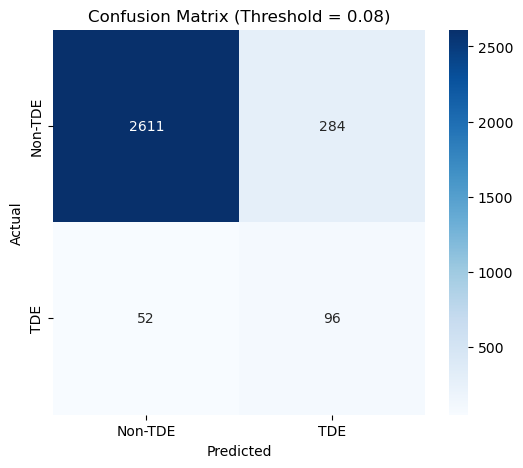

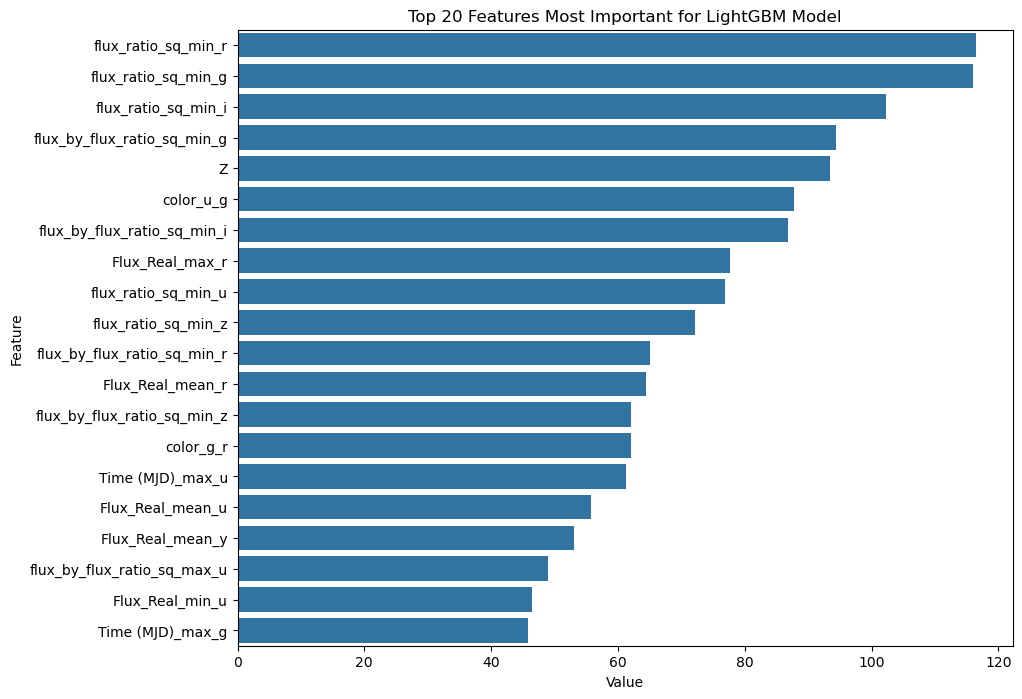

In [231]:
from typing import final
import matplotlib.pyplot as plt
import seaborn as sns

final_preds = (oof_preds_proba >= best_threshold).astype(int)
cm = confusion_matrix(y, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 3. Plot Feature Importance
feature_cols_for_plot = feature_cols_last_fold if 'feature_cols_last_fold' in globals() else feature_cols_full
feature_imp = pd.DataFrame({'Feature': feature_cols_for_plot, 'Value': 0})
for model in models:
    feature_imp['Value'] += model.feature_importances_
feature_imp['Value'] /= len(models)

plt.figure(figsize=(10, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('Top 20 Features Most Important for LightGBM Model')
plt.show()


In [232]:
# --- BUILD SUBMISSION (Competition metric = F1, requires binary labels) ---
# Recreate test features with the same pipeline
sample_sub = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
test_log = pd.read_csv(os.path.join(DATA_DIR, "test_log.csv"))

test_df = process_data_pipeline(test_log, is_train=False)

# Apply the same NA/outlier handling using full-train stats (no leakage from CV)
# 1) Drop columns that were removed in full train
if len(cols_drop_full) > 0:
    test_df = test_df.drop(columns=[c for c in cols_drop_full if c in test_df.columns], errors='ignore')

# 2) Drop rows missing object_id (target không có trong test)
test_df = test_df.dropna(subset=['object_id'])

# 3) Fill NA using full-train medians/modes
num_cols_test = [c for c in num_cols_full if c in test_df.columns and c not in cols_drop_full]
cat_cols_test = [c for c in cat_cols_full if c in test_df.columns and c not in cols_drop_full]
if len(num_cols_test) > 0:
    test_df[num_cols_test] = test_df[num_cols_test].fillna(train_num_median_full[num_cols_test])
if len(cat_cols_test) > 0 and not train_cat_mode_full.empty:
    test_df[cat_cols_test] = test_df[cat_cols_test].fillna(train_cat_mode_full[cat_cols_test])

# 4) Clip outliers using full-train percentiles
if len(num_cols_test) > 0:
    test_df[num_cols_test] = test_df[num_cols_test].clip(
        lower=lower_full.reindex(num_cols_test),
        upper=upper_full.reindex(num_cols_test),
        axis=1
    )

# Align columns to training feature set
feature_cols = feature_cols_full
missing = [c for c in feature_cols if c not in test_df.columns]
for c in missing:
    test_df[c] = 0
extra = [c for c in test_df.columns if c not in feature_cols and c != 'object_id']
if extra:
    test_df = test_df.drop(columns=extra)

# Reorder to match training
X_test = test_df.set_index('object_id')[feature_cols]

# Predict probabilities and apply optimal threshold
test_probas = np.column_stack([m.predict_proba(X_test)[:, 1] for m in models]).mean(axis=1)
test_preds = (test_probas >= best_threshold).astype(int)

# Build submission aligned to sample_sub order
sub = sample_sub.copy()
sub = sub.set_index('object_id')
sub.loc[X_test.index, 'prediction'] = test_preds
sub = sub.reset_index()

# Save submission
sub.to_csv('submission.csv', index=False)
print('Saved submission.csv with binary predictions using optimal F1 threshold.')


Processing mallorn-challenge/Split_01\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_02\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_03\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_04\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_05\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_06\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_07\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_04\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_05\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_06\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_07\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_08\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_09\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_10\test_full_lightcurves.csv...
Processing mallorn-challenge/Split_11\test_full_lightcurves.cs